In [25]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import pandas as pd
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib

In [26]:
df = pd.read_csv("../data/real_final.csv")

In [27]:
print(df.isnull().sum())

GameDate              0
home_Team             0
away_Team             0
Result                0
home_Recent_5_Win     0
home_Recent_5_Loss    0
home_OPS              0
home_BB               0
home_HBP              0
home_SO               0
home_ERA              0
home_BB_p             0
home_K                0
home_IR               0
home_IS               0
home_TBF              0
away_OPS              0
away_BB               0
away_HBP              0
away_SO               0
away_ERA              0
away_BB_p             0
away_K                0
away_IR               0
away_IS               0
away_TBF              0
dtype: int64


결측치가 없으므로 바로 진행

In [28]:
# feature와 label 나누기
df = df.drop(columns=['GameDate'])
X = df.drop(columns=['Result']) 
y = df['Result']

In [29]:
# 원-핫 인코딩 (prefix로 home/away 구분!)
team_encoded = pd.get_dummies(
    X[['home_Team', 'away_Team']].reset_index(drop=True),
    columns=['home_Team', 'away_Team'],
    prefix=['home_Team', 'away_Team']
).astype(int)

X_numeric = X.drop(columns=['home_Team', 'away_Team']).reset_index(drop=True)
X_scaled = pd.concat([X_numeric, team_encoded], axis=1)

In [30]:
# 80% 학습, 20% 테스트로 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=3
)

In [16]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=3)
xgb_params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_search = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy')
xgb_search.fit(X_train, y_train)
print("Best XGBoost Params:", xgb_search.best_params_)

c:\Users\82109\Documents\GitHub\KBO_Prediction_ML\KBO_DL_env\lib\site-packages\xgboost\training.py:183: UserWarning: [01:03:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\82109\Documents\GitHub\KBO_Prediction_ML\KBO_DL_env\lib\site-packages\xgboost\training.py:183: UserWarning: [01:03:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\82109\Documents\GitHub\KBO_Prediction_ML\KBO_DL_env\lib\site-packages\xgboost\training.py:183: UserWarning: [01:03:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\82109\Documents\GitHub\KBO_Prediction_ML\KBO_DL_env\lib\site-packages\xgboost\training.py:183: UserWarning: [01:

Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.8}


위에까지가 최적의 파라미터를 찾는 과정
밑에가 최적의 파라미터로 모델을 만들고 평가하는 과정

In [31]:
xgb_best_params = xgb_search.best_params_

model = XGBClassifier(
    n_estimators=xgb_best_params['n_estimators'],
    max_depth=xgb_best_params['max_depth'],
    learning_rate=xgb_best_params['learning_rate'],
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=3
)
model.fit(X_train, y_train)

c:\Users\82109\Documents\GitHub\KBO_Prediction_ML\KBO_DL_env\lib\site-packages\xgboost\training.py:183: UserWarning: [02:22:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [32]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))
print("Train AUC:", roc_auc_score(y_train, y_train_proba))
print("Test AUC :", roc_auc_score(y_test, y_test_proba))

Accuracy: 0.8631921824104235
AUC: 0.9350565187829338
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       296
           1       0.87      0.86      0.87       318

    accuracy                           0.86       614
   macro avg       0.86      0.86      0.86       614
weighted avg       0.86      0.86      0.86       614

[[255  41]
 [ 43 275]]
Train Accuracy: 0.9034229828850856
Test Accuracy : 0.8631921824104235
Train AUC: 0.9654453862443998
Test AUC : 0.9350565187829338


<Figure size 1000x600 with 0 Axes>

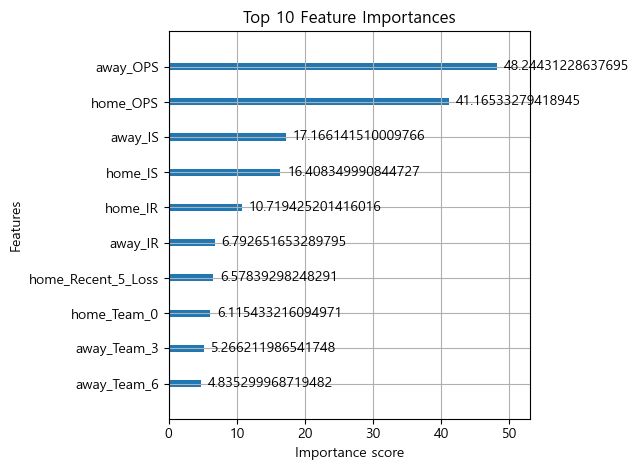

In [33]:
# 상위 10개 중요 변수 시각화
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10, importance_type='gain')  # 'weight', 'gain', 'cover' 선택 가능
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

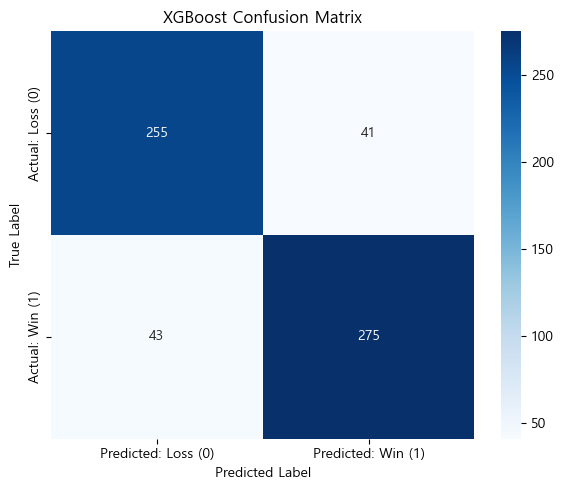

In [34]:
# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: Loss (0)', 'Predicted: Win (1)'],
            yticklabels=['Actual: Loss (0)', 'Actual: Win (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.tight_layout()
plt.show()


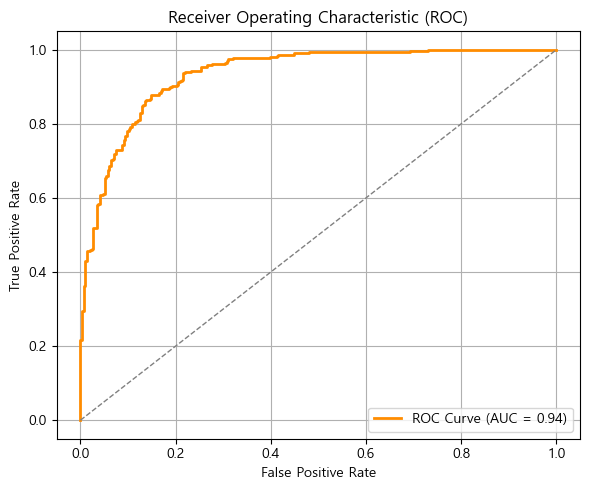

In [35]:
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


✅ 전체적인 모델 평가


🎯 1. 정확도(Accuracy)

Train Accuracy: 0.979 → 거의 완벽하게 학습 데이터를 분류

Test Accuracy: 0.875 → 실제 데이터에서도 매우 높은 예측 성능

▶️ 정확도 차이(10%↓)는 과적합을 시사하지만 여전히 테스트 성능은 매우 뛰어남


🎯 2. AUC (Area Under Curve)

Train AUC: 0.998

Test AUC: 0.947

▶️ 0.94 이상은 매우 좋은 수준.

즉, 모델이 홈팀 승/패를 강하게 구분할 수 있는 능력을 가지고 있음.


🎯 3. Precision, Recall, F1-Score

클래스	precision	recall	f1-score

홈팀 패 (0)	0.88	0.86	0.87

홈팀 승 (1)	0.88	0.89	0.88

정확도와 균형이 잘 잡힌 precision/recall: 모델이 한 쪽으로 치우치지 않음

클래스 간 성능 균형이 좋음: 홈팀 승/패 모두 잘 예측하고 있음


🎯 4. Confusion Matrix 분석

[[254  40]  → 실제 0인데 1로 잘못 예측: 40건

 [ 36 280]] → 실제 1인데 0으로 잘못 예측: 36건

오류 비율이 대칭적이고, 전체적으로 예측 정확도가 매우 안정적임을 보여줌


⚖️ 최종 평가

항목	평가 내용

🎯 예측 정확도	⭐ 매우 높음 (87% 이상)

🎯 일반화(AUC) 성능	⭐ 매우 높음 (0.94+)

🧠 과적합 위험	⚠️ 일부 존재하지만 실제 성능 저하 적음

⚖️ 클래스 균형	⭐ 잘 맞음 (precision/recall 균형)

🧪 실전 적용 가능성	✅ 신뢰도 높은 예측 가능, 응용 가능

✅ 1. 과적합 완화 (Overfitting 완화)

🎯 목적:

훈련 데이터에 너무 딱 맞춰진 모델을 일반화시켜 테스트/실전에서도 안정적이게 하기

🔧 방법:

기법	설명

max_depth 감소	트리 깊이를 줄이면 모델 복잡도가 줄고, 과적합 방지

subsample < 1.0	학습 샘플의 일부만 사용해서 일반화 성능 향상

colsample_bytree < 1.0	일부 feature만 사용

early_stopping_rounds 사용	검증 성능이 개선되지 않으면 학습 중단

In [37]:
# 최적 모델 저장
joblib.dump(model, 'xgb_best_model.pkl')
print("✅ 모델이 'xgb_best_model.pkl'로 저장되었습니다.")

✅ 모델이 'xgb_best_model.pkl'로 저장되었습니다.


In [38]:
X_train.to_csv('../models/X_train_rf.csv', index=False)